# Startup success analysis

**Task**: Perform some rigorous analysis that can be used to identify relevant factors and score prospective startups based on their potential to be successful.

In [54]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

Load the data
- Set dates columns
- Replace "No Info" and "unknown amount" with nan value

In [55]:
data = pd.read_csv('data/Startup_Data.csv', na_values=['No Info','unknown amount'], parse_dates=['Est. Founding Date', 'Last Funding Date'])
print(data.shape)
data.head()

(472, 116)


,Company_Name,Dependent-Company Status,year of founding,Age of company in years,Internet Activity Score,Short Description of company profile,Industry of company,Focus functions of company,Investors,Employee Count,...,Percent_skill_Data Science,Percent_skill_Business Strategy,Percent_skill_Product Management,Percent_skill_Sales,Percent_skill_Domain,Percent_skill_Law,Percent_skill_Consulting,Percent_skill_Finance,Percent_skill_Investment,Renown score
0,Company1,Success,NaN,NaN,-1.0,Video distribution,NaN,operation,KPCB Holdings|Draper Fisher Jurvetson (DFJ)|Kl...,3.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,Company2,Success,2011.0,3.0,125.0,NaN,Market Research|Marketing|Crowdfunding,"Marketing, sales",NaN,NaN,...,8.823529,21.764706,10.882353,2.941176,0.000000,0.0,0.0,0.0,0.0,8.0
2,Company3,Success,2011.0,3.0,455.0,Event Data Analytics API,Analytics|Cloud Computing|Software Development,operations,TechStars|Streamlined Ventures|Amplify Partner...,14.0,...,3.846154,17.094017,9.401709,0.000000,2.777778,0.0,0.0,0.0,0.0,9.0
3,Company4,Success,2009.0,5.0,-99.0,The most advanced analytics for mobile,Mobile|Analytics,Marketing & Sales,Michael Birch|Max Levchin|Sequoia Capital|Keit...,45.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,5.0
4,Company5,Success,2010.0,4.0,496.0,The Location-Based Marketing Platform,Analytics|Marketing|Enterprise Software,Marketing & Sales,DFJ Frontier|Draper Nexus Ventures|Gil Elbaz|A...,39.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,6.0


Remove columns with high proportion of missing data - 5 columns

In [56]:
MISSING_PERCENTAGE = 0.36
cols_to_drop = data.isnull().sum() / len(data)
print(cols_to_drop[cols_to_drop > MISSING_PERCENTAGE])
data = data.dropna(axis=1,how='all', thresh=(1-MISSING_PERCENTAGE)*len(data))
data.shape

Employees count MoM change                   0.434322
Employee benefits and salary structures      0.743644
Client Reputation                            0.580508
Gartner hype cycle stage                     0.364407
Time to maturity of technology (in years)    0.364407
dtype: float64


(472, 111)

Remove useless data

In [57]:
del data['year of founding'] #in most cases same as Age of company in years
#(2014 - data['year of founding'] != data['Age of company in years'])

Remove whitespaces and lowercase all the strings. Example shows values in different letter cases.

In [58]:
print('Example:')
print(data['Has the team size grown'].unique())

num_data = data.select_dtypes(include=[np.number]) 
#num_data.describe()
str_data = data.select_dtypes(include=['object']) 
#str_data.describe()

parser = lambda x: str(x).lower().strip() if pd.isnull(x) == False else x
str_data = str_data.applymap(parser)
#str_data.describe()
df = pd.concat([num_data, str_data], axis=1)
#df.head()
print(df['Has the team size grown'].unique())

Example:
['No' 'Yes' 'yes' nan 'YES']
['no' 'yes' nan]


Create numerical target column where '1' means success and '0' means failure.

In [59]:
df['Target'] = df['Dependent-Company Status'].map( {'failed': 0, 'success': 1} )

## Success prediction

### Categorical variables correlation to target variable
We are showing count plot for all values on the left side to see if their counts are significant (e.g. more than 50 in total (10%)). On the right side is correlation between categorical variables and target variable. NaN values are filled as a most frequent value from a particular column. Insights:
- ~85% of global players succeed
- startups with medium and high number of sales support material succeed in more than ~85% of cases
- focus on consumer data is also relatively good predictor of success in ~80% of cases
- at least few partners of company are very good
- machine learning, predictive nalytics, Big Data business has more than 80% chance to succeed
- B2B has significant correlation with success while B2C has lower correlation with success
- high experience in selling and building products and high number of research publications is more than 90% correlated with success 

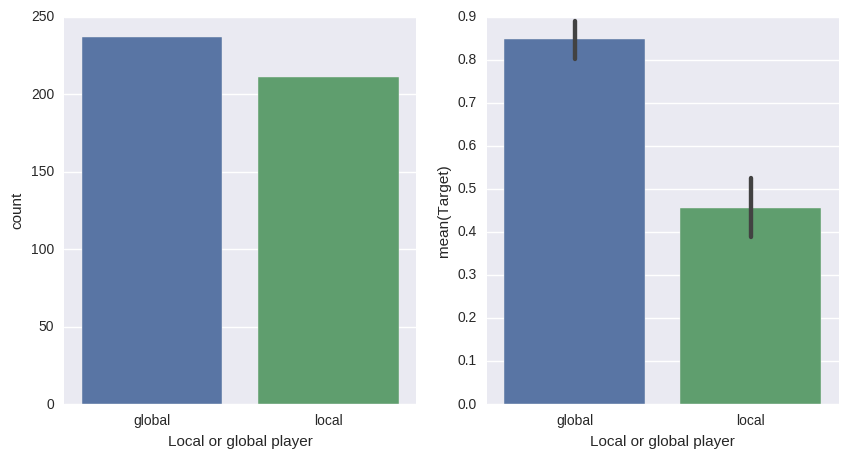

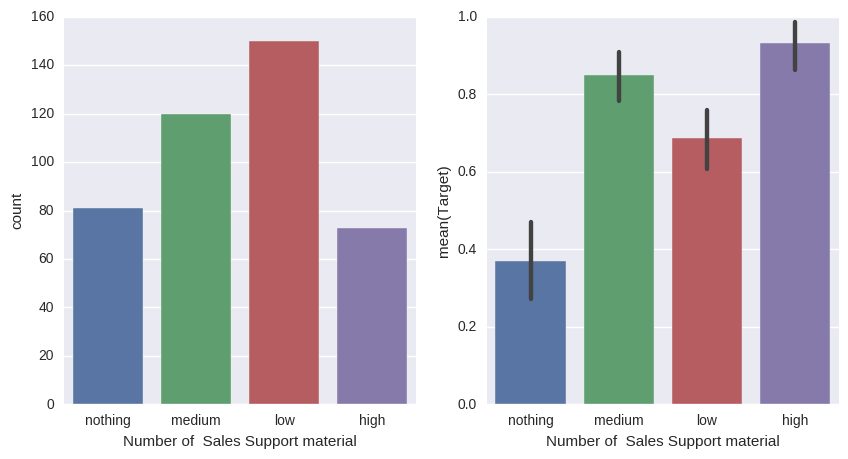

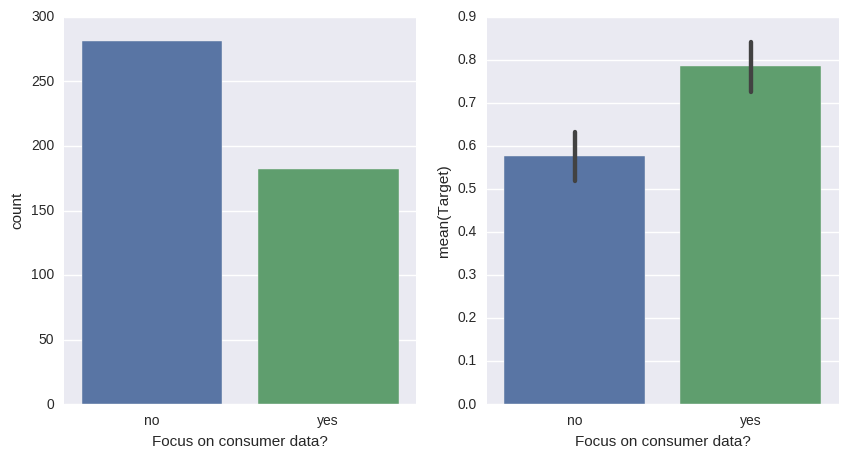

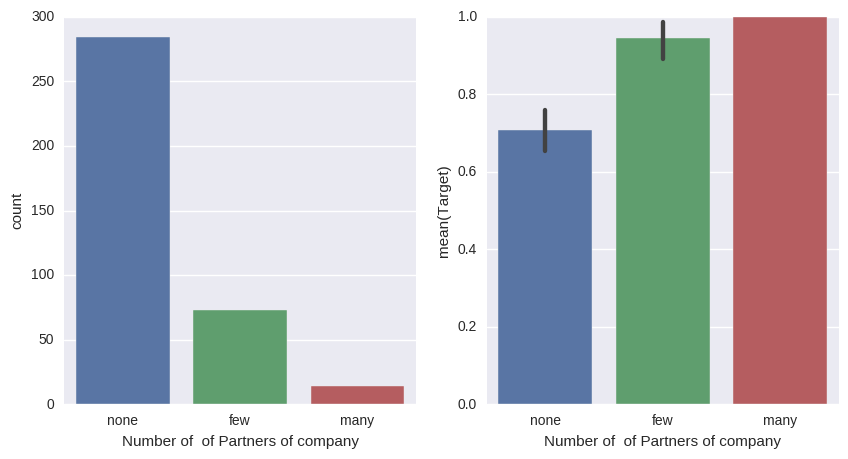

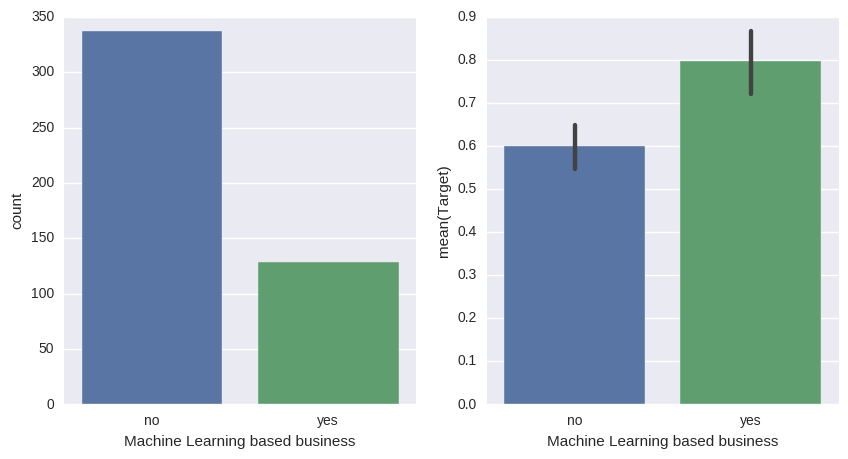

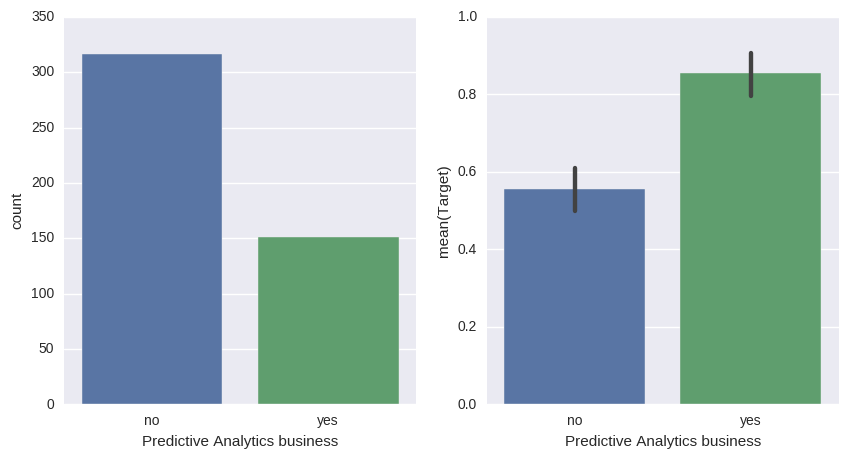

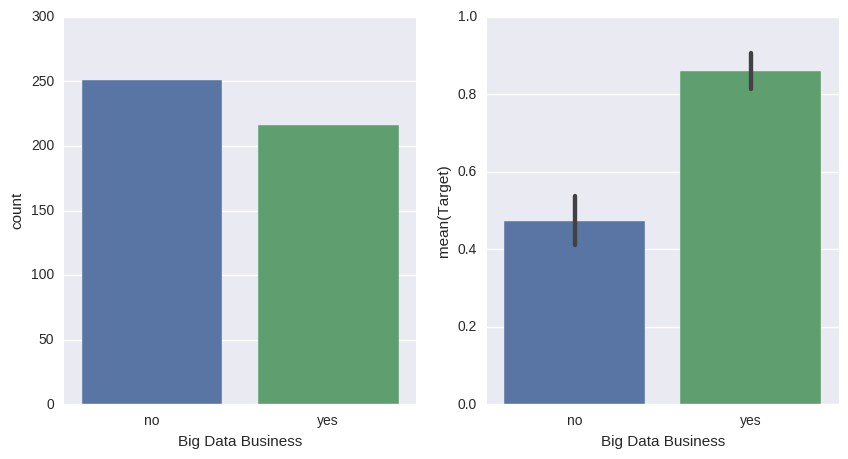

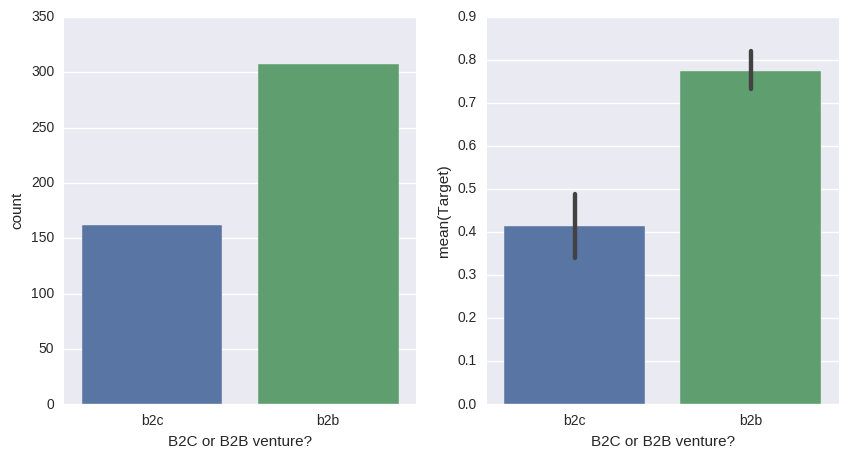

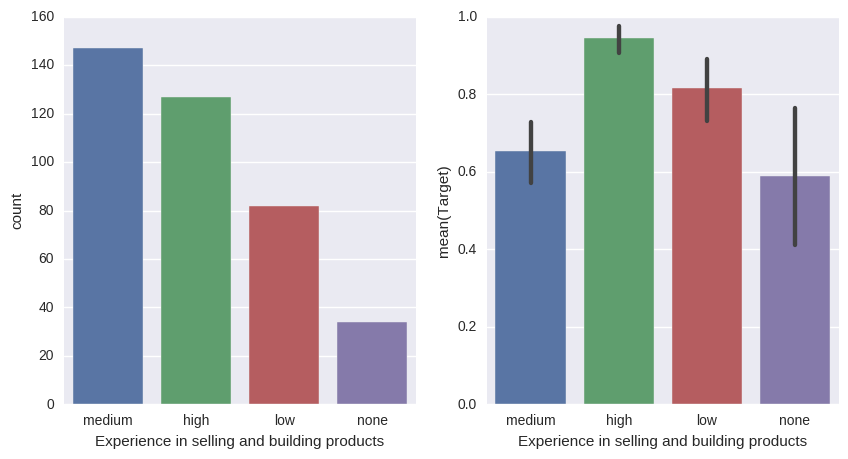

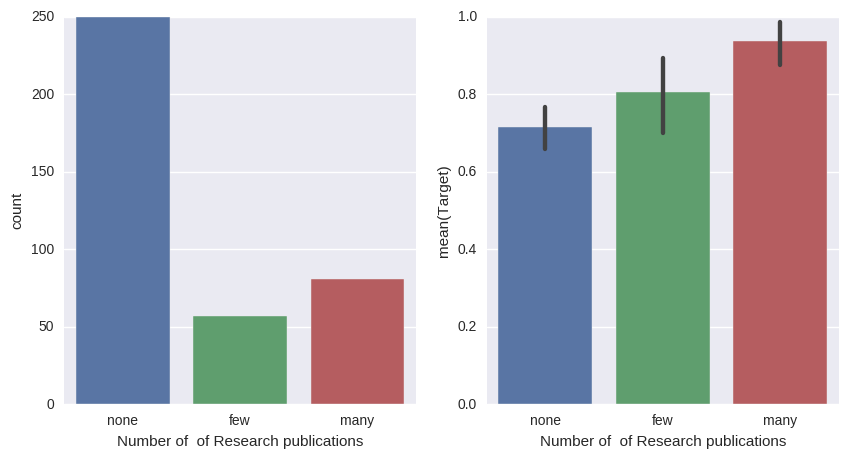

In [60]:
features = ['Local or global player', 'Number of  Sales Support material', 'Focus on consumer data?', 
            'Number of  of Partners of company', 'Machine Learning based business', 'Predictive Analytics business',
            'Big Data Business', 'B2C or B2B venture?', 'Experience in selling and building products', 'Number of  of Research publications']

for attr_name in features:
    fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

    df[attr_name].fillna(df[attr_name].dropna().mode(), inplace=True)
    
    # sns.factorplot('Person',data=titanic_df,kind='count',ax=axis1)
    sns.countplot(x=attr_name, data=df, ax=axis1)

    # average
    sns.barplot(x=attr_name, y='Target', data=df, ax=axis2)

### Feature engineering
We are going to create new columns derived from inverstors and industry and take a look if there is a relationship in number of investors in startup or number of industries a startup is focusing.

In [61]:
#df['Investors'].describe()
pipe_parser = lambda x: str(x).count('|')
df['investors_count'] = df['Investors'].apply(pipe_parser)
df['industry_count'] = df['Industry of company'].apply(pipe_parser)

### Numerical variables correlation to target variable
To find numerical variables correlation we used histogram of values and strip plot . Before plotting, outliers are clipped to 0.05 or 0.95 quantile and NaN are computed as median of a particular column.
Startup should be successful if:
- number of inverstors in seed is more than 3
- more than 30 employees
- more than 3 angel or VC investors
- number of recognitions for founders and co-founders is more than 200
- percent of data science skills more than 16
- number of investors is more than 7
- number of industries is more than 2

(0.0, 7.0)
(0.0, 128.75)
(0.0, 3.8999999999999773)
(0.0, 361.5)
(0.0, 11.22004357)
(0.0, 25.0)
(0.0, 9.449999999999989)
(0.0, 3.0)


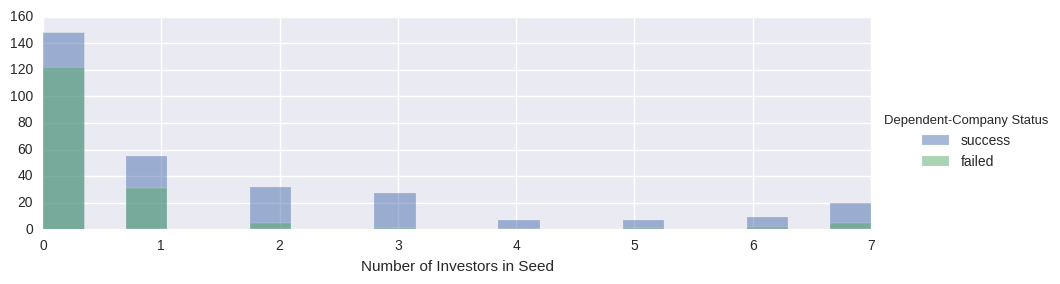

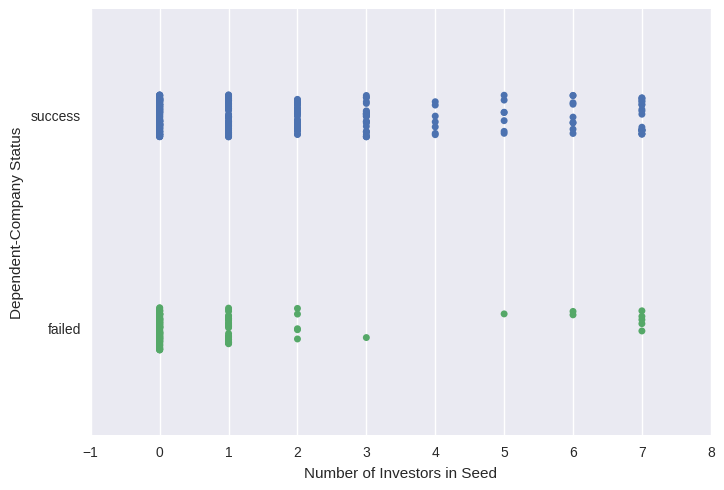

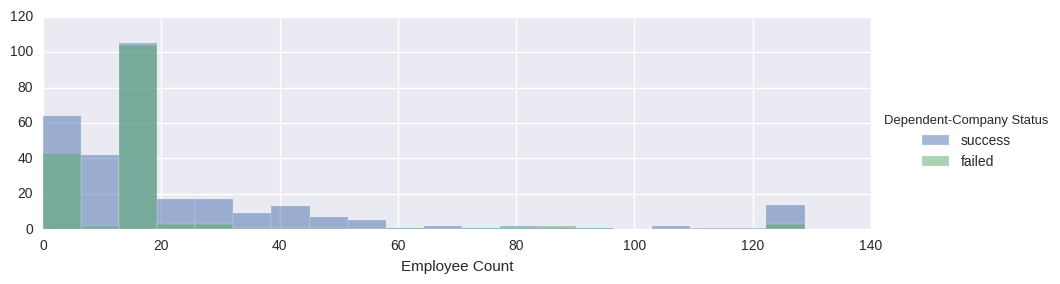

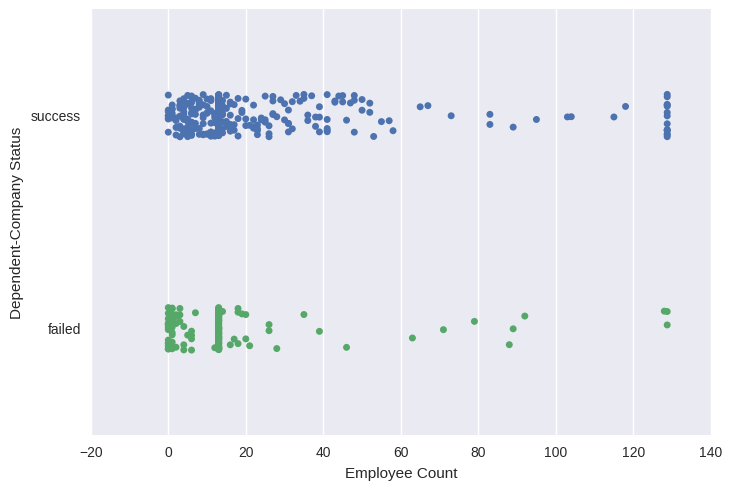

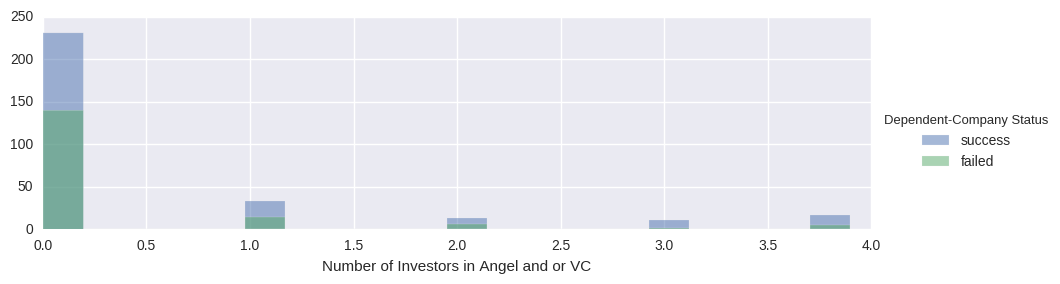

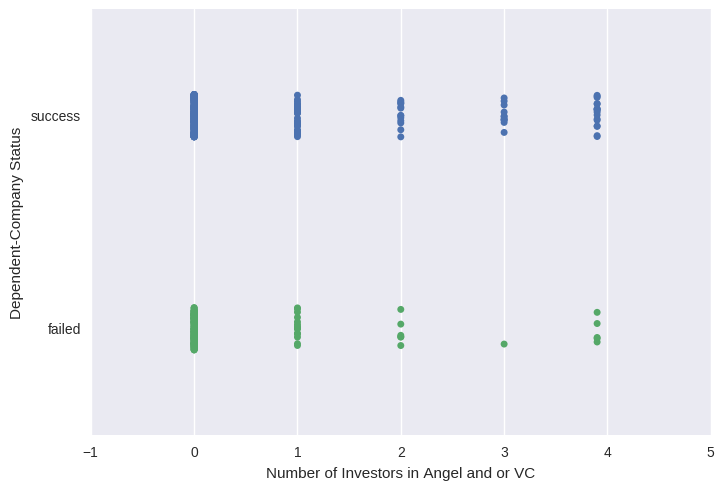

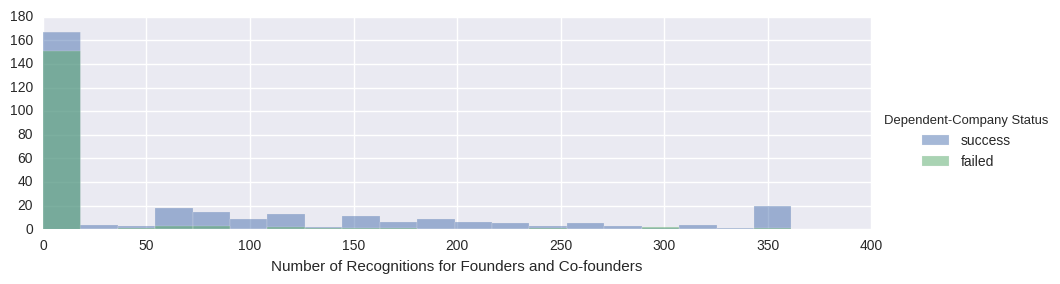

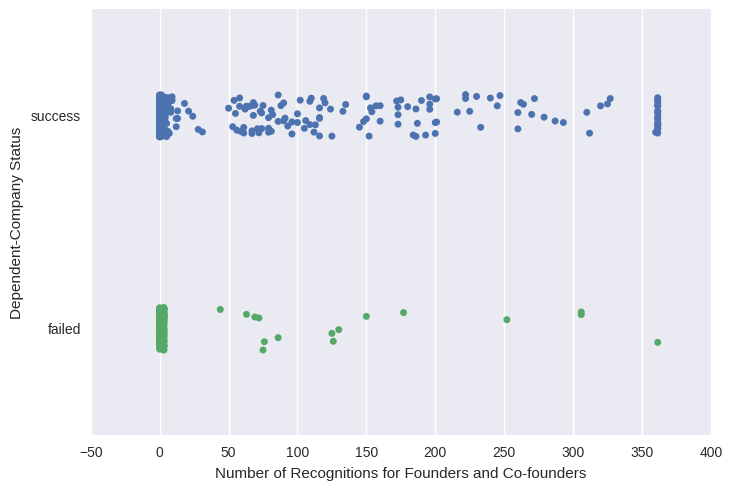

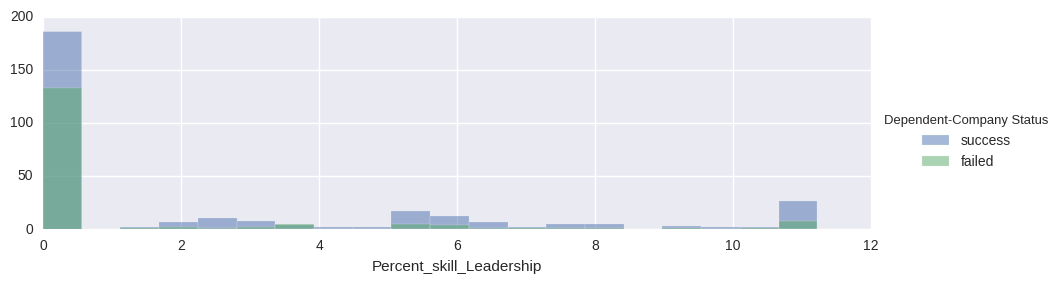

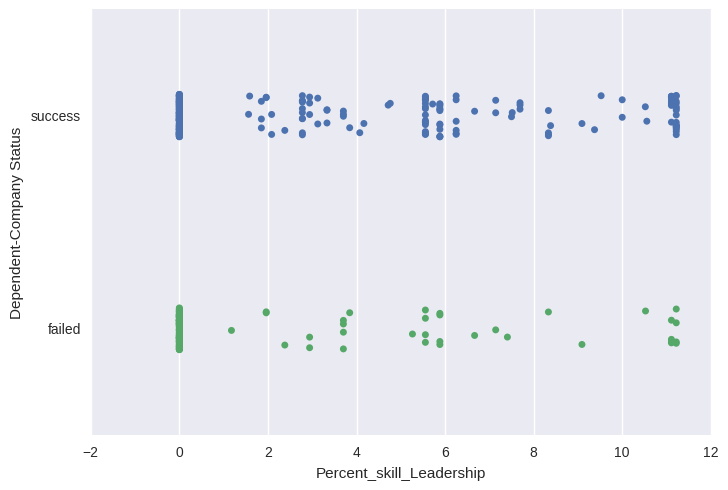

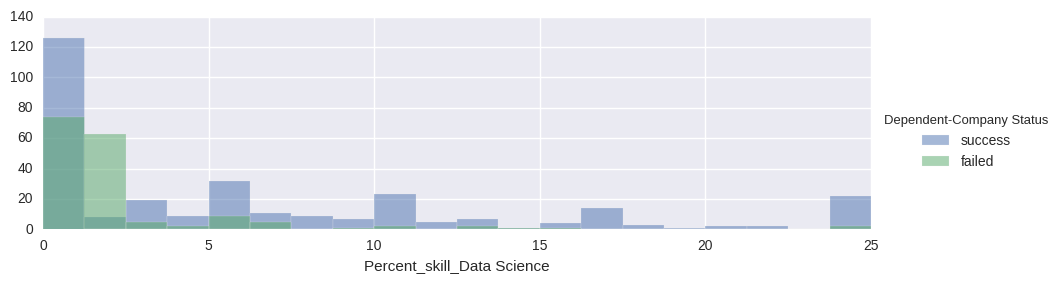

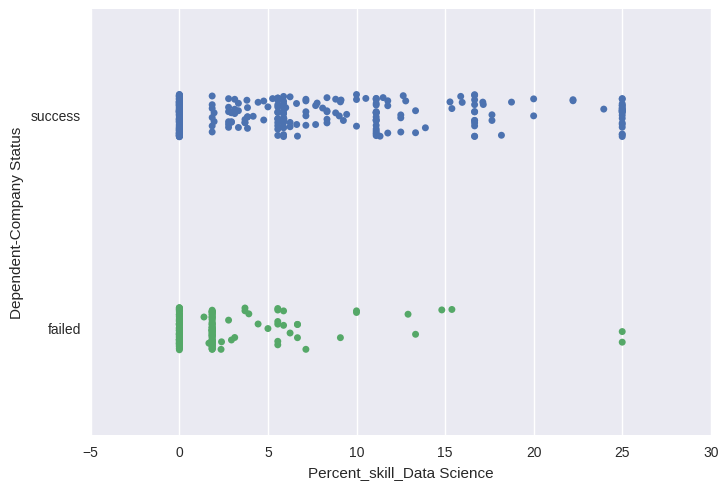

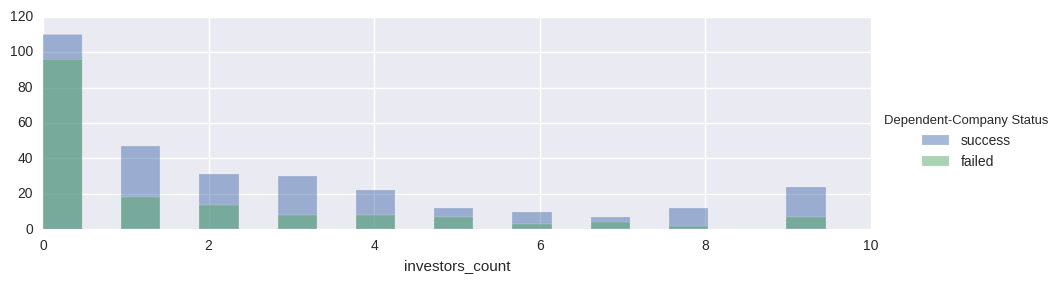

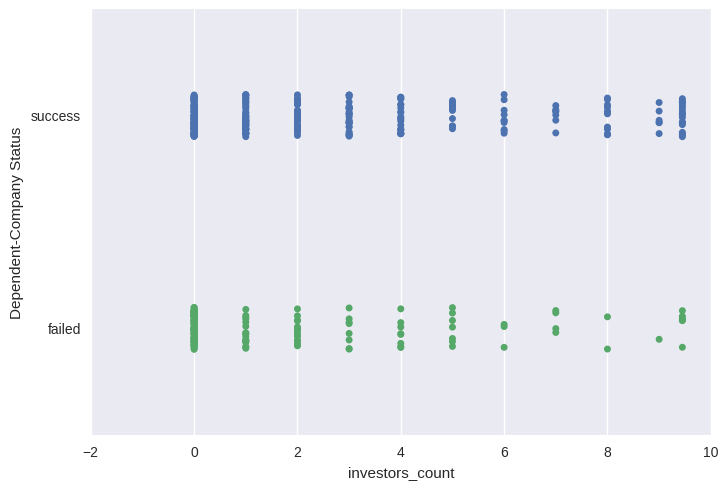

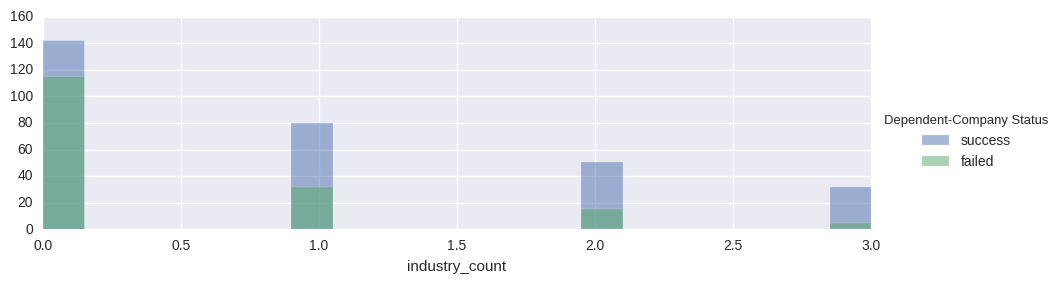

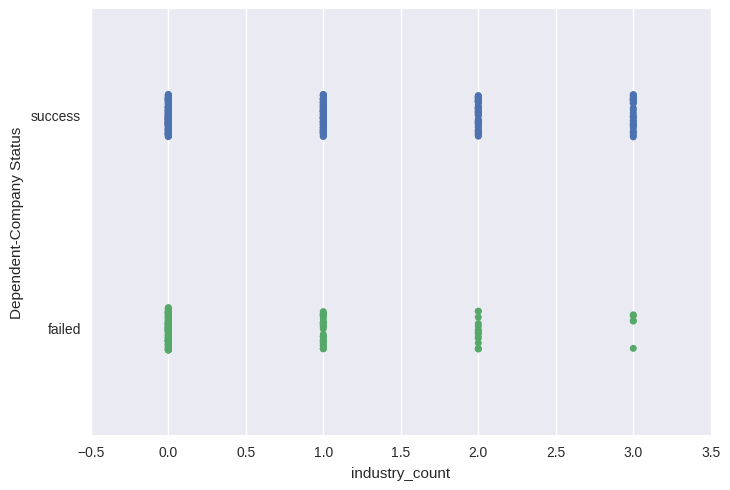

In [62]:
features = ['Number of Investors in Seed','Employee Count','Number of Investors in Angel and or VC', 
            'Number of Recognitions for Founders and Co-founders', 'Percent_skill_Leadership',
            'Percent_skill_Data Science', 'investors_count', 'industry_count']

for attr_name in features:
    q1 = df[attr_name].quantile(0.05)
    q3 = df[attr_name].quantile(0.95)
    print(q1, q3)
    df[attr_name] = df[attr_name].clip(q1,q3)
    
    df[attr_name].fillna(df[attr_name].dropna().median(), inplace=True)
    
    facet = sns.FacetGrid(df, hue="Dependent-Company Status",aspect=3)
    facet.map(plt.hist,attr_name, alpha=.5, bins=20)
    facet.add_legend()
    
    plt.figure()
    sns.stripplot(data=df, x=attr_name, y="Dependent-Company Status", jitter=True)
    
    #plt.figure()
    #sns.boxplot(x=attr_name, y="Dependent-Company Status", data=df, whis=np.inf)

In the next step, I found most successful [VC companies](https://www.entrepreneur.com/article/242702). If we invest in startups where **Y Combinator**, **Andreessen Horowitz** or **Sequoia Capital** have invested before, we have more than **85%** chance to invest in successful startup.

In [63]:
big_investors = 'y combinator|andreessen horowitz|sequoia capital'
df['big_investors'] = df['Investors'].str.contains(big_investors, na=False).astype(int)
df[(df['big_investors'] == 1)]["Target"].sum() / float(df['big_investors'].sum())

0.85185185185185186

### Classification models
In this step, statistical classification model is trained and it's most significant features for predictions are analyzed. Full dataset is split into 70% of data used for training and 30% of data are for testing and evaluation of prediction. NaN values are filled as median of a particular column.

In [64]:
def features_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

((330, 12), (330,), (142, 12), (142,))
             precision    recall  f1-score   support

          0       0.59      0.78      0.67        45
          1       0.88      0.75      0.81        97

avg / total       0.79      0.76      0.77       142



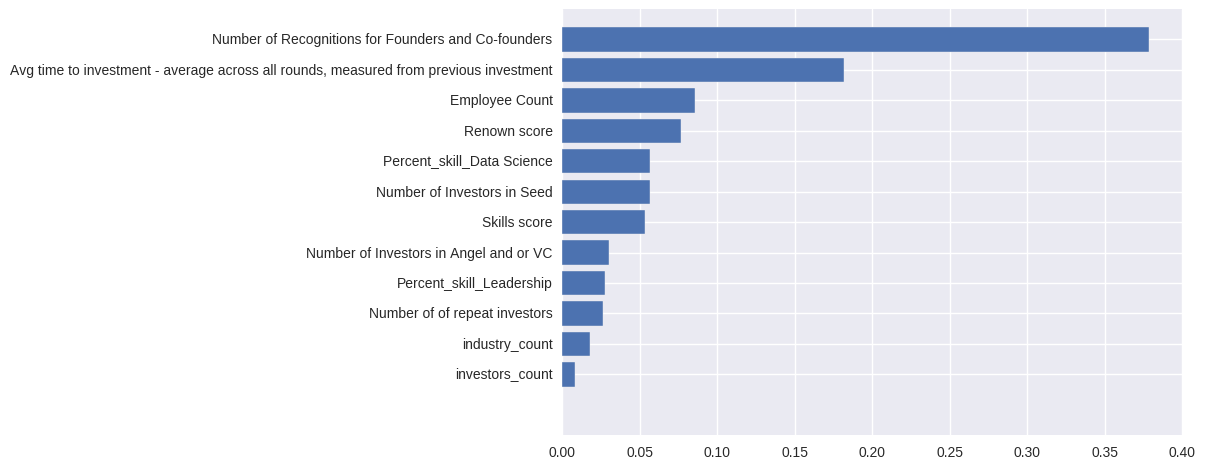

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

model_df = df[['Target', 'Number of Investors in Seed','Employee Count','Number of Investors in Angel and or VC', 
            'Number of Recognitions for Founders and Co-founders', 'Percent_skill_Leadership',
            'Percent_skill_Data Science', 'investors_count', 'industry_count', 
            'Number of of repeat investors', 'Skills score', 'Avg time to investment - average across all rounds, measured from previous investment', 'Renown score'
              ]]

model_df = model_df.fillna(model_df.median())
train, test = train_test_split(model_df, test_size = 0.3, random_state=42)

X_train = train.drop("Target", axis=1)
Y_train = train["Target"]
X_test = test.drop("Target", axis=1)
Y_test = test["Target"]
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

classifier = DecisionTreeClassifier(class_weight='balanced')
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))
# .reshape(classifier.coef_.shape[1])
features_importances(classifier.feature_importances_, model_df.drop('Target', axis=1))

Feature importances for **decision tree** classifier are shown in the image above. It can be seen that number of recognitions, employee count and average time to invest are the most significant features for the classifier, which means that they are positively correlated and important to take into account.

It is possible to visualize the decision tree and find the most useful combinations of features. [TODO](http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html#sklearn.tree.export_graphviz)

### Statistical tests
Correlation between features and target variable by statistical tests.

- Anova
- chi-square

**Number of recognitions** and **data science skills** are most significant correlated features in both tests.

('ANOVA f-values: ', array([ 25.76253386,  10.10611032,   5.3500386 ,  48.63390352,
        13.42121228,  43.77701887,  12.41741159,  24.49088528,
        14.14111397,   0.10689582,   8.24178356,   0.61901621]))
('ANOVA p-values: ', array([  5.57268278e-07,   1.57531318e-03,   2.11527069e-02,
         1.05154132e-11,   2.77107679e-04,   1.00461349e-10,
         4.66954948e-04,   1.04203881e-06,   1.90983847e-04,
         7.43851821e-01,   4.27847213e-03,   4.31809632e-01]))


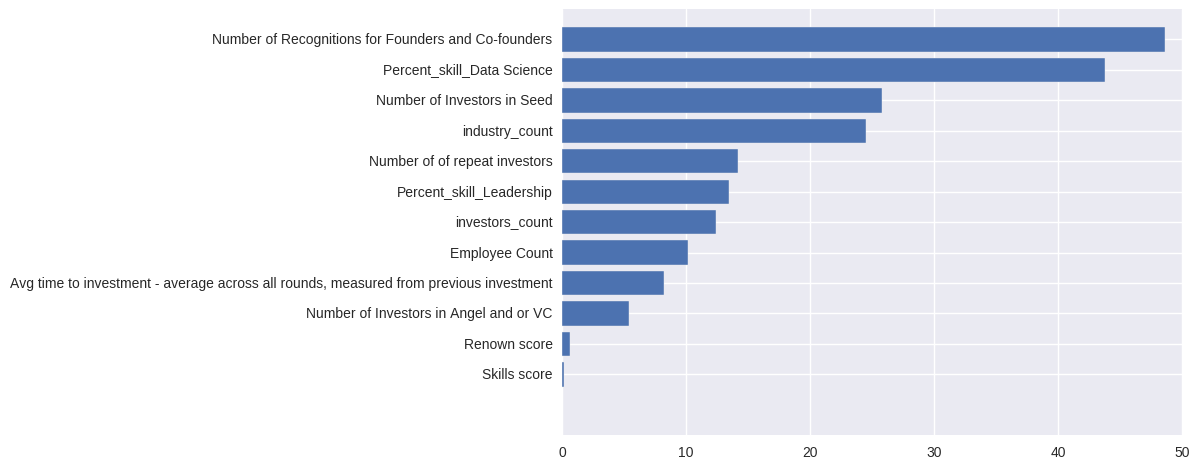

('CHi2 f-values: ', array([  7.85551603e+01,   3.53592750e+02,   1.21466639e+01,
         7.66759435e+03,   7.85985926e+01,   3.82033516e+02,
         4.50602401e+01,   2.91058325e+01,   3.48644396e+01,
         1.07883208e+00,   1.27040352e+02,   1.32148899e+00]))
('Chi2 p-values: ', array([  7.77953513e-19,   6.99485390e-79,   4.91757487e-04,
         0.00000000e+00,   7.61036151e-19,   4.48989155e-85,
         1.91065541e-11,   6.85303601e-08,   3.53478267e-09,
         2.98958976e-01,   1.82034442e-29,   2.50324998e-01]))


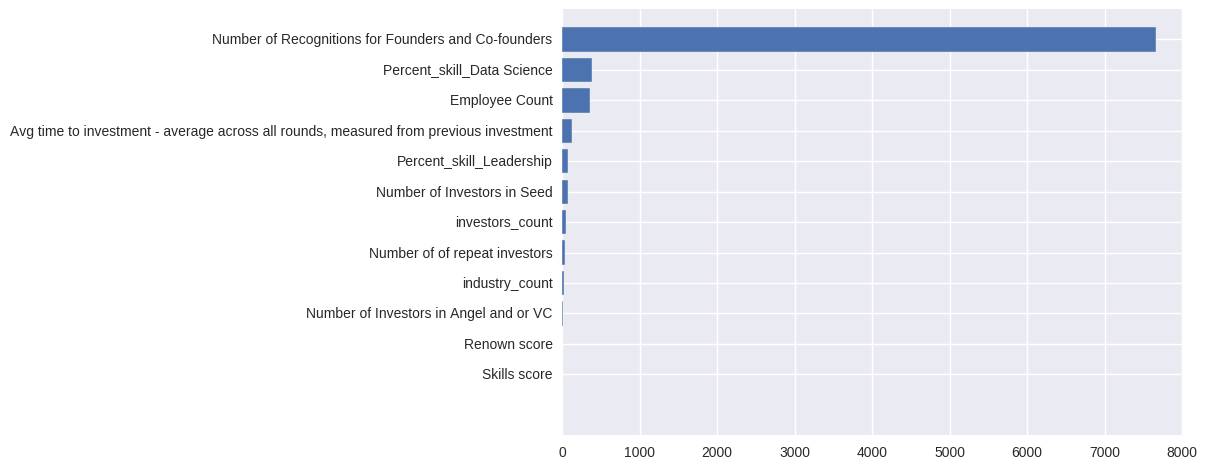

In [66]:
from sklearn import feature_selection

scores, pvaues = feature_selection.f_classif(model_df.drop('Target', axis=1).as_matrix(), model_df['Target'].as_matrix())
print('ANOVA f-values: ', scores)
print('ANOVA p-values: ', pvaues)
features_importances(scores, model_df.drop('Target', axis=1))

scores, pvaues = feature_selection.chi2(model_df.drop('Target', axis=1).as_matrix(), model_df['Target'].as_matrix())
print('CHi2 f-values: ', scores)
print('Chi2 p-values: ', pvaues)
features_importances(scores, model_df.drop('Target', axis=1))

### Other ideas
- dummy variables for classifier - more features by converting categorical features to numerical